In [1]:
!pip install pandas seaborn
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML

pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
df = None
results = []
provers = ["z3_4_8_5", "z3_4_8_9", "z3_4_8_17", "cvc4_1_8", "cvc5_1_0_8", "gappa_1_4_0", "altergo_2_5_4"]
kinds = ["machine", "math"]

for kind in kinds:
    for prover in provers:
        csv = pd.read_csv("../results_" + kind + "_" + prover + ".csv")
        csv = csv.rename(columns={
            'result': 'result_' + kind + "_" + prover,
            'time': 'time_' + kind + "_" + prover,
            'steps': 'steps_' + kind + "_" + prover,
        })
        results.append('result_' + kind + "_" + prover)
        if df is None:
            df = csv
        else:
            df = df.merge(csv, how='outer', on=['file', 'kind', 'goal'])

<Axes: ylabel='prover'>

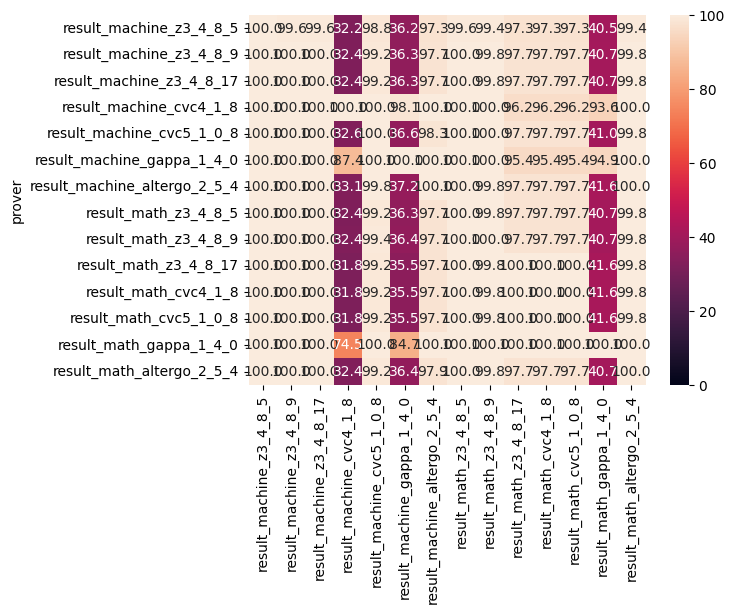

In [3]:
# Percentage of tests that pass for every prover where they pass

columns = [f"result_{k}_{p}" for k in kinds for p in provers]

df_res = df.filter(regex=r'^result_') \
    .apply(lambda r: r.apply(lambda c: int(c == "Valid"))) \
    .reset_index() \

dfs = []

for column in columns:
    tab = df_res[df_res[column] == 1].copy(deep=True)
    count = len(tab.index)
    tab["prover"] = column
    tab = tab.groupby(["prover"]).sum()
    tab = tab.apply(lambda r: r.apply(lambda c: 100 * c / count))
    del tab['index']
    dfs.append(tab)

df_all = pd.concat(dfs)
sns.heatmap(df_all, annot=True, fmt="2.1f", vmin=0, vmax=100)

<Axes: ylabel='prover'>

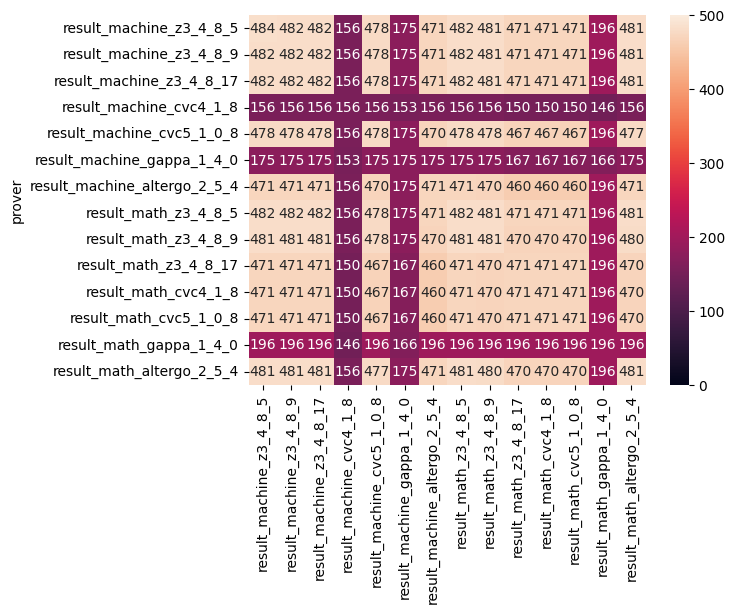

In [4]:
# Number of tests that pass for every prover where they pass

columns = [f"result_{k}_{p}" for k in kinds for p in provers]

df_res = df.filter(regex=r'^result_') \
    .apply(lambda r: r.apply(lambda c: int(c == "Valid"))) \
    .reset_index() \

dfs = []

for column in columns:
    tab = df_res[df_res[column] == 1].copy(deep=True)
    tab["prover"] = column
    tab = tab.groupby(["prover"]).sum()
    del tab['index']
    dfs.append(tab)

df_all = pd.concat(dfs)
sns.heatmap(df_all, annot=True, fmt="2.0f", vmin=0, vmax=500)

<Axes: >

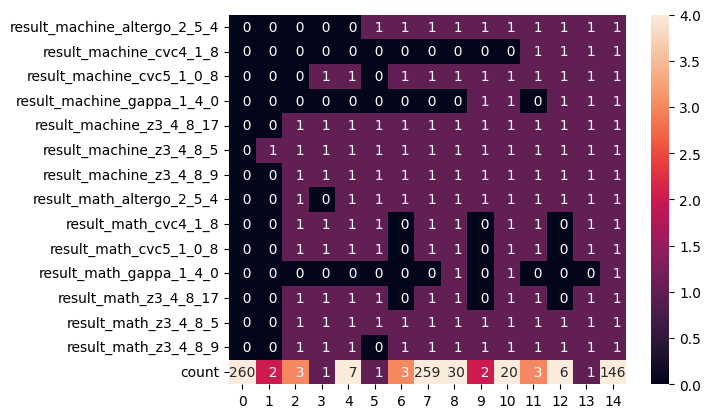

In [5]:
columns = sorted([f"result_{k}_{p}" for k in kinds for p in provers])
df_res = df.filter(regex=r'^result_').reset_index().apply(lambda r: r.apply(lambda c: 1 if c == "Valid" else 0)) \
    .groupby(columns).count().reset_index().rename(columns={"index": "count"})

df_res = df_res.sort_values(columns).loc[:, columns + ["count"]].reset_index(drop=True)

sns.heatmap(df_res.transpose(), fmt="3.0f", annot=True, vmin=0, vmax=4)

In [6]:
for i, row in df_res.iterrows():
    cond = None
    for idx, value in row.items():
        if idx == "count":
            continue
        
        this_cond = df[idx] == "Valid"
        if not value:
            this_cond = ~this_cond
        
        if cond is None:
            cond = this_cond
        else:
            cond = cond & this_cond

    df_row = pd.DataFrame(row).transpose()
    df_row.style.hide(axis="index")

    display(HTML(f"<hr><h1>Result kind row {i}:</h1>"))
    display(df_row)
    df_res = df[cond].loc[:, ["kind", "goal"]].sort_values(["kind", "goal"]).reset_index(drop=True)
    display(df_res)
    df_res.to_csv(f"{i}.csv", index=False)


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,260


,kind,goal
0,cfg,byteback.test.algorithm.ArrayReverse.apply(RI)V
1,cfg,byteback.test.algorithm.ArrayReverse.reverse(RI)V
2,cfg,byteback.test.algorithm.ArrayReverse.reverse(RI)V
3,cfg,byteback.test.algorithm.ArrayReverse.swap(RIII)V
4,cfg,byteback.test.algorithm.ArrayReverse.swap(RIII)V
5,cfg,byteback.test.algorithm.ArrayReverse.swap(RIII)V
6,cfg,byteback.test.algorithm.BinarySearch.search(RIIII)I
7,cfg,byteback.test.algorithm.Counter.incrementTo10()V
8,cfg,byteback.test.algorithm.DoubleInsertionSort.sort(RD)V
9,cfg,byteback.test.algorithm.DoubleMax.max(RD)D


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2


,kind,goal
0,cfg,byteback.test.library.java.util.AbstractCollection.finishToArray(RLJava.Lang.Object;LJava.Util.Iterator;)RLJava.Lang.Object;
1,cfg,byteback.test.library.java.util.ArrayList.grow(I)V


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
2,0,0,0,0,1,1,1,1,1,1,0,1,1,1,3


,kind,goal
0,cfg,byteback.test.exceptions.Basic.catchesIfEven()V
1,cfg,byteback.test.exceptions.Basic.catchesIfEven()V
2,cfg,byteback.test.exceptions.Basic.catchesIfEven()V


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
3,0,0,1,0,1,1,1,0,1,1,0,1,1,1,1


,kind,goal
0,cfg,byteback.test.library.java.util.ArrayList$SubList.iterator()LJava.Util.Iterator;


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
4,0,0,1,0,1,1,1,1,1,1,0,1,1,1,7


,kind,goal
0,cfg,byteback.test.array.Basic.constructors()V
1,cfg,byteback.test.exceptions.TryWithResources.emptyTryWithResourcesFinally()V
2,cfg,byteback.test.exceptions.TryWithResources.tryWithResourcesClosesResource()V
3,cfg,byteback.test.library.java.util.ArrayList$SubList.<init>(LByteback.Test.Library.Java.Util.ArrayList;LByteback.Test.Library.Java.Util.AbstractList;III)V
4,cfg,byteback.test.library.java.util.LinkedList.clear()V
5,cfg,byteback.test.switchexpression.Basic.switchInteger()V
6,cfg,byteback.test.switchexpression.Basic.switchYieldInteger()V


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
5,1,0,0,0,1,1,1,1,1,1,0,1,1,0,1


,kind,goal
0,cfg,byteback.test.exceptions.Basic.throwsAlternatingExceptions()V


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
6,1,0,1,0,1,1,1,1,0,0,0,0,1,1,3


,kind,goal
0,cfg,byteback.test.exceptions.PotentialIndexOutOfBounds.passedArrayAndIndex(RII)V
1,cfg,byteback.test.exceptions.PotentialIndexOutOfBounds.passedTarget(RI)V
2,cfg,byteback.test.exceptions.PotentialIndexOutOfBounds.passedTarget(RI)V


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
7,1,0,1,0,1,1,1,1,1,1,0,1,1,1,259


,kind,goal
0,cfg,byteback.test.algorithm.ArrayReverse.<init>()V
1,cfg,byteback.test.algorithm.ArrayReverse.<init>()V
2,cfg,byteback.test.algorithm.ArrayReverse.<init>()V
3,cfg,byteback.test.algorithm.BinarySearch.<init>()V
4,cfg,byteback.test.algorithm.Counter.<init>()V
5,cfg,byteback.test.algorithm.Counter.increment()V
6,cfg,byteback.test.algorithm.Counter.setCount(I)V
7,cfg,byteback.test.algorithm.DoubleInsertionSort.<init>()V
8,cfg,byteback.test.algorithm.DoubleMax.<init>()V
9,cfg,byteback.test.algorithm.DoubleSelectionSort.<init>()V


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
8,1,0,1,0,1,1,1,1,1,1,1,1,1,1,30


,kind,goal
0,cfg,byteback.test.typeinference.Basic.inferPrimitives()V
1,function,byteback.test.algorithm.Counter.getCount()I
2,function,byteback.test.exceptions.Basic.f()I
3,function,byteback.test.exceptions.Basic.getF()I
4,function,byteback.test.instance.Counter.count()I
5,function,byteback.test.instance.FieldAccess.fieldReference()I
6,function,byteback.test.instance.FieldAccess.fieldSum()I
7,predicate,byteback.test.examples.ReadResource$Resource.has_next()Z
8,predicate,byteback.test.examples.ReadResource$Resource.has_no_next()Z
9,predicate,byteback.test.examples.ReadResource$Resource.is_closed()Z


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
9,1,0,1,1,1,1,1,1,0,0,0,0,1,1,2


,kind,goal
0,predicate,byteback.test.algorithm.DoubleSelectionSort.is_minimum(RDII)Z
1,predicate,byteback.test.algorithm.IntegerSelectionSort.is_minimum(RIII)Z


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
10,1,0,1,1,1,1,1,1,1,1,1,1,1,1,20


,kind,goal
0,cfg,byteback.test.instance.StaticField.initialized()Z
1,cfg,byteback.test.instance.Unit.identity(LJava.Lang.Object;)LJava.Lang.Object;
2,cfg,byteback.test.instance.Unit.identity(LJava.Lang.Object;)LJava.Lang.Object;
3,cfg,byteback.test.operation.VirtualCall.proceduralGetThis()LByteback.Test.Operation.VirtualCall;
4,function,byteback.test.operation.VirtualCall.getThis()LByteback.Test.Operation.VirtualCall;
5,predicate,byteback.test.algorithm.ArrayReverse.bounded_indices(RIII)Z
6,predicate,byteback.test.algorithm.DoubleSelectionSort.bounded_indices(RDII)Z
7,predicate,byteback.test.algorithm.DoubleSum.positive_arguments_imply_positive_sum(RDD)Z
8,predicate,byteback.test.algorithm.GCD.result'020is'020gcd(III)Z
9,predicate,byteback.test.algorithm.GCD.result_is_gcd(III)Z


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
11,1,1,1,0,1,1,1,1,1,1,0,1,1,1,3


,kind,goal
0,cfg,byteback.test.library.java.util.LinkedList.peek()LJava.Lang.Object;
1,cfg,byteback.test.library.java.util.LinkedList.peekFirst()LJava.Lang.Object;
2,cfg,byteback.test.library.java.util.LinkedList.peekLast()LJava.Lang.Object;


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
12,1,1,1,1,1,1,1,1,0,0,0,0,1,1,6


,kind,goal
0,cfg,byteback.test.array.Basic.lengthReference(RI)V
1,predicate,byteback.test.algorithm.ArrayReverse.bounded_index(RII)Z
2,predicate,byteback.test.algorithm.DoubleSelectionSort.bounded_index(RDI)Z
3,predicate,byteback.test.algorithm.IntegerSelectionSort.bounded_index(RII)Z
4,predicate,byteback.test.examples.ReadResource.a_is_empty(LByteback.Test.Examples.ReadResource$Resource;RII)Z
5,predicate,byteback.test.exceptions.PotentialIndexOutOfBounds.array_is_empty(RI)Z


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
13,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1


,kind,goal
0,cfg,byteback.test.patternmatching.Basic.test()I


,result_machine_altergo_2_5_4,result_machine_cvc4_1_8,result_machine_cvc5_1_0_8,result_machine_gappa_1_4_0,result_machine_z3_4_8_17,result_machine_z3_4_8_5,result_machine_z3_4_8_9,result_math_altergo_2_5_4,result_math_cvc4_1_8,result_math_cvc5_1_0_8,result_math_gappa_1_4_0,result_math_z3_4_8_17,result_math_z3_4_8_5,result_math_z3_4_8_9,count
14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,146


,kind,goal
0,cfg,byteback.test.casting.BoolToInt.implicit()I
1,cfg,byteback.test.casting.IntToReal.explicit()D
2,cfg,byteback.test.casting.IntToReal.implicit()D
3,cfg,byteback.test.casting.RealToInt.explicit()I
4,cfg,byteback.test.controlflow.Basic.$anonfun$emptyFor$1(I)V
5,cfg,byteback.test.controlflow.Basic.assignIf()V
6,cfg,byteback.test.controlflow.Basic.assignParameter(I)V
7,cfg,byteback.test.controlflow.Basic.doubleAssignment()V
8,cfg,byteback.test.controlflow.Basic.doubleAssignment(I)I
9,cfg,byteback.test.controlflow.Basic.empty()V
